# 🌱 Drone AI Agriculture - Model Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xybronix/drone-ai-agriculture/blob/main/ml/notebooks/training_colab.ipynb)

This notebook trains the agricultural classification model for:
- 🌿 Plant Detection
- 🪴 Species Identification
- 📈 Growth Stage Evaluation
- 🏥 Health Diagnosis

**Requirements:** GPU runtime recommended (Runtime → Change runtime type → T4 GPU)"

## 1. Environment Setup

In [1]:
# Check GPU availability
!nvidia-smi

Tue Jan  6 15:12:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Clone the repository
!git clone https://github.com/Xybronix/drone-ai-agriculture.git
%cd drone-ai-agriculture

Cloning into 'drone-ai-agriculture'...
remote: Enumerating objects: 20780, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 20780 (delta 2), reused 2 (delta 1), pack-reused 20772 (from 2)
Receiving objects: 100% (20780/20780), 328.12 MiB | 41.42 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (41325/41325), done.
/content/drone-ai-agriculture


In [3]:
# Install dependencies
!pip install -q tensorflow==2.19.0 albumentations kaggle tf2onnx onnx pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [4]:
# Verify TensorFlow and GPU
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Kaggle Configuration

To download datasets from Kaggle, you need to configure your API credentials.

### Option A: Using Colab Secrets (Recommended)
1. Click the 🔑 icon in the left sidebar
2. Add two secrets:
   - `KAGGLE_USERNAME`: Your Kaggle username
   - `KAGGLE_KEY`: Your Kaggle API key

### Option B: Upload kaggle.json\n",
1. Go to https://www.kaggle.com/settings
2. Click \"Create New Token\" to download kaggle.json
3. Upload it when prompted below

In [5]:
import os

# Try to get credentials from Colab secrets
try:
    from google.colab import userdata
    os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
    os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
    print("✅ Kaggle credentials loaded from Colab secrets")
except Exception as e:
    print(f"⚠️ Could not load from secrets: {e}")
    print("Please upload your kaggle.json file:")

    from google.colab import files
    uploaded = files.upload()

    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ kaggle.json configured")

⚠️ Could not load from secrets: Secret KAGGLE_USERNAME does not exist.
Please upload your kaggle.json file:


Saving kaggle.json to kaggle (1).json
✅ kaggle.json configured


## 3. Download Dataset

In [6]:
# List available datasets
!python ml/download_datasets.py --list

2026-01-06 15:15:03,638 - INFO - Dataset Manager initialized
2026-01-06 15:15:03,638 - INFO - Environment: colab
2026-01-06 15:15:03,638 - INFO - Dataset path: data/datasets
2026-01-06 15:15:03,638 - INFO - Cache path: data/cache

Available Datasets

plantvillage
  Name: PlantVillage Dataset
  Description: 38 classes of plant diseases
  Source: kaggle
  Size: ~2500 MB
  Expected Classes: 38
  Expected Images: 54303
  Status: ✓ Downloaded (61602 images, 15 classes)
  Use for: health, species

plant_seedlings
  Name: Plant Seedlings Dataset
  Description: 12 species of plant seedlings
  Source: kaggle
  Size: ~800 MB
  Expected Classes: 12
  Expected Images: 5539
  Status: ○ Not downloaded
  Use for: species, growth_stage

crop_diseases
  Name: Crop Disease Dataset
  Description: Multiple crop diseases
  Source: kaggle
  Size: ~3000 MB
  Expected Classes: 38
  Expected Images: 87000
  Status: ○ Not downloaded
  Use for: health, species

mini_dataset
  Name: Mini Test Dataset
  Descriptio

In [7]:
# Download PlantVillage dataset (recommended for training)
# This may take a few minutes depending on your connection
# !python ml/download_datasets.py --download plantvillage
!python ml/download_datasets.py --download-all

2026-01-06 15:15:04,631 - INFO - Dataset Manager initialized
2026-01-06 15:15:04,631 - INFO - Environment: colab
2026-01-06 15:15:04,631 - INFO - Dataset path: data/datasets
2026-01-06 15:15:04,631 - INFO - Cache path: data/cache
2026-01-06 15:15:04,631 - INFO - Starting download of all datasets...
2026-01-06 15:15:04,631 - INFO - 
2026-01-06 15:15:04,631 - INFO - Processing: plantvillage
2026-01-06 15:15:04,631 - INFO - ========================================
2026-01-06 15:15:04,631 - INFO - Dataset plantvillage already exists at data/datasets/plantvillage
2026-01-06 15:15:04,631 - INFO - Use --force to re-download
2026-01-06 15:15:04,631 - INFO - 
2026-01-06 15:15:04,631 - INFO - Processing: plant_seedlings
2026-01-06 15:15:04,631 - INFO - ========================================
2026-01-06 15:15:04,632 - INFO - ============================================================
2026-01-06 15:15:04,632 - INFO - Downloading: Plant Seedlings Dataset
2026-01-06 15:15:04,632 - INFO - Descripti

In [8]:
# Alternative: Download mini dataset for quick testing
# !python ml/download_datasets.py --download mini_dataset

In [9]:
# Verify the dataset

print("Vérification du dataset Plant Village")
!python ml/download_datasets.py --verify plantvillage

Vérification du dataset Plant Village
2026-01-06 15:19:13,744 - INFO - Dataset Manager initialized
2026-01-06 15:19:13,744 - INFO - Environment: colab
2026-01-06 15:19:13,744 - INFO - Dataset path: data/datasets
2026-01-06 15:19:13,744 - INFO - Cache path: data/cache
2026-01-06 15:19:14,214 - INFO - Dataset: plantvillage
2026-01-06 15:19:14,214 - INFO - Path: data/datasets/plantvillage
2026-01-06 15:19:14,214 - INFO - Total images: 61602
2026-01-06 15:19:14,214 - INFO - Classes: 15
2026-01-06 15:19:14,214 - INFO -   Pepper__bell___Bacterial_spot: 2991 images
2026-01-06 15:19:14,214 - INFO -   Pepper__bell___healthy: 4430 images
2026-01-06 15:19:14,214 - INFO -   Potato___Early_blight: 3000 images
2026-01-06 15:19:14,214 - INFO -   Potato___Late_blight: 3000 images
2026-01-06 15:19:14,214 - INFO -   Potato___healthy: 456 images
2026-01-06 15:19:14,214 - INFO -   Tomato_Bacterial_spot: 6381 images
2026-01-06 15:19:14,214 - INFO -   Tomato_Early_blight: 3000 images
2026-01-06 15:19:14,214

## 4. Explore the Dataset

In [10]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import random

# Set dataset path
# DATASET_PATH = Path('./data/datasets/plantvillage')

# If using mini dataset:
DATASET_PATH = Path('./data/datasets/mini_dataset')

# Get class names
class_names = sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()])
print(f"Found {len(class_names)} classes:")
for i, name in enumerate(class_names[:10]):
    print(f"  {i+1}. {name}")
if len(class_names) > 10:
    print(f"  ... and {len(class_names) - 10} more")

Found 5 classes:
  1. deficiency
  2. disease_a
  3. disease_b
  4. healthy
  5. pest_damage


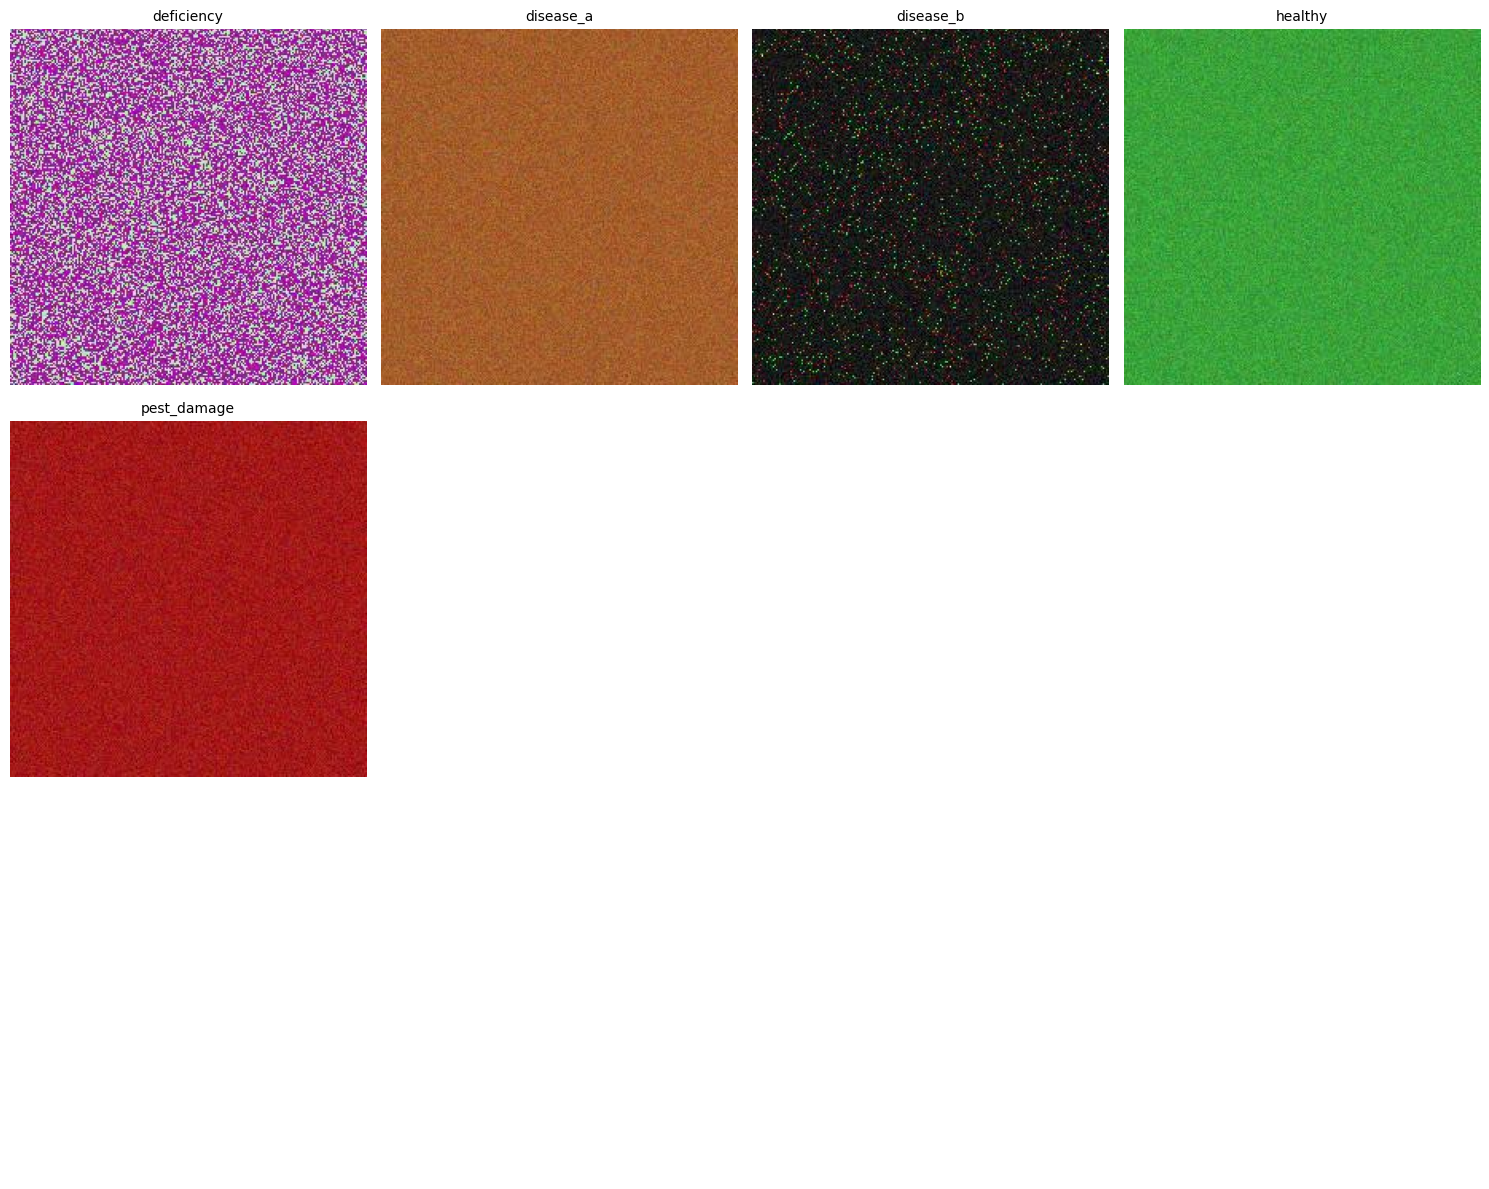

In [11]:
# Visualize sample images
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(class_names):
        class_dir = DATASET_PATH / class_names[i]
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG')) + list(class_dir.glob('*.png'))
        if images:
            img_path = random.choice(images)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(class_names[i][:20], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Configure Training

In [12]:
# Training configuration
CONFIG = {
    'dataset_path': str(DATASET_PATH),
    'output_dir': './output',
    'model_name': 'agriculture_model',
    'backbone': 'efficientnet',  # or 'mobilenet'
    'epochs': 30,
    'fine_tune_epochs': 15,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'image_size': (224, 224),
    'validation_split': 0.2,
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training Configuration:
  dataset_path: data/datasets/mini_dataset
  output_dir: ./output
  model_name: agriculture_model
  backbone: efficientnet
  epochs: 30
  fine_tune_epochs: 15
  batch_size: 32
  learning_rate: 0.0001
  image_size: (224, 224)
  validation_split: 0.2


## 6. Train the Model

In [13]:
# Run training using the training script
!python ml/train_model.py \
    --dataset {CONFIG['dataset_path']} \
    --output {CONFIG['output_dir']} \
    --model-name {CONFIG['model_name']} \
    --backbone {CONFIG['backbone']} \
    --epochs {CONFIG['epochs']} \
    --fine-tune-epochs {CONFIG['fine_tune_epochs']} \
    --batch-size {CONFIG['batch_size']} \
    --learning-rate {CONFIG['learning_rate']}

2026-01-06 15:19:15.989806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767712756.009803    3152 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767712756.015819    3152 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767712756.031814    3152 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767712756.031841    3152 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767712756.031846    3152 computation_placer.cc:177] computation placer alr

## 7. Evaluate Results

In [14]:
# Load training summary
import json

with open('./output/training_summary.json', 'r') as f:
    summary = json.load(f)

print("="*60)
print("TRAINING RESULTS")
print("="*60)
print(f"Model: {summary['model_name']}")
print(f"Backbone: {summary['backbone']}")
print(f"Classes: {summary['num_classes']}")
print(f"\nFinal Metrics:")
for metric, value in summary['final_metrics'].items():
    print(f"  {metric}: {value:.4f}")
print("="*60)

TRAINING RESULTS
Model: agriculture_model
Backbone: efficientnet
Classes: 5

Final Metrics:
  loss: 1.2045
  compile_metrics: 0.4005


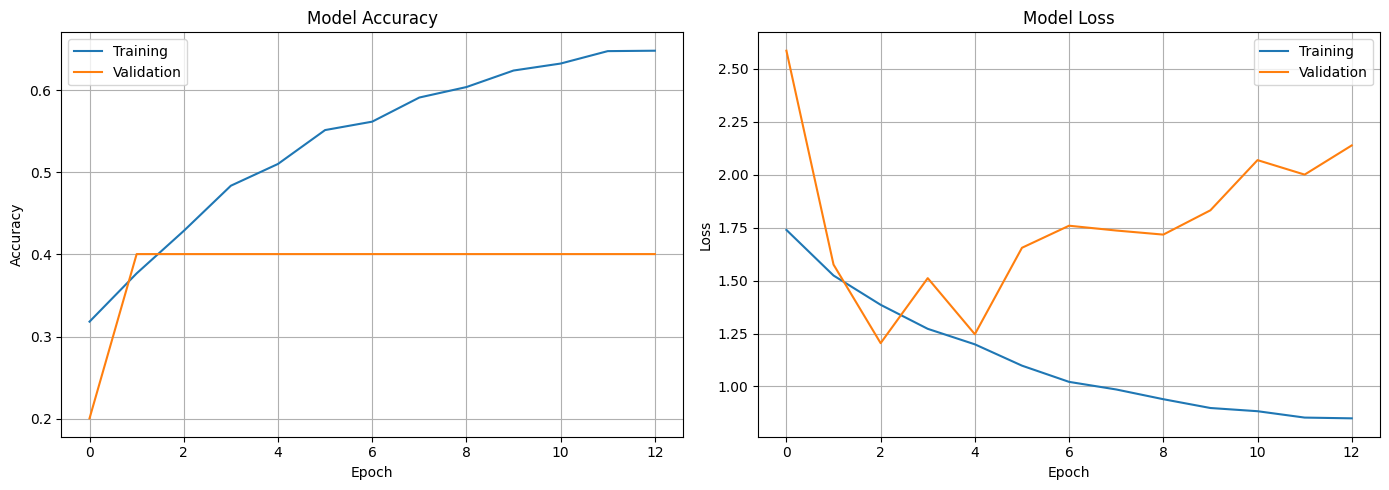

In [15]:
# Plot training history
import pandas as pd

history_df = pd.read_csv('./output/logs/training_log.csv')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_df['accuracy'], label='Training')
axes[0].plot(history_df['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history_df['loss'], label='Training')
axes[1].plot(history_df['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('./output/training_curves.png', dpi=150)
plt.show()

## 8. Test the Model

In [16]:
# Load the trained model
from tensorflow import keras
import numpy as np

model = keras.models.load_model('./output/models/agriculture_model.h5')

# Load class names
with open('./output/models/class_names.json', 'r') as f:
    class_names = json.load(f)

print(f"Model loaded with {len(class_names)} classes")

Model loaded with 5 classes


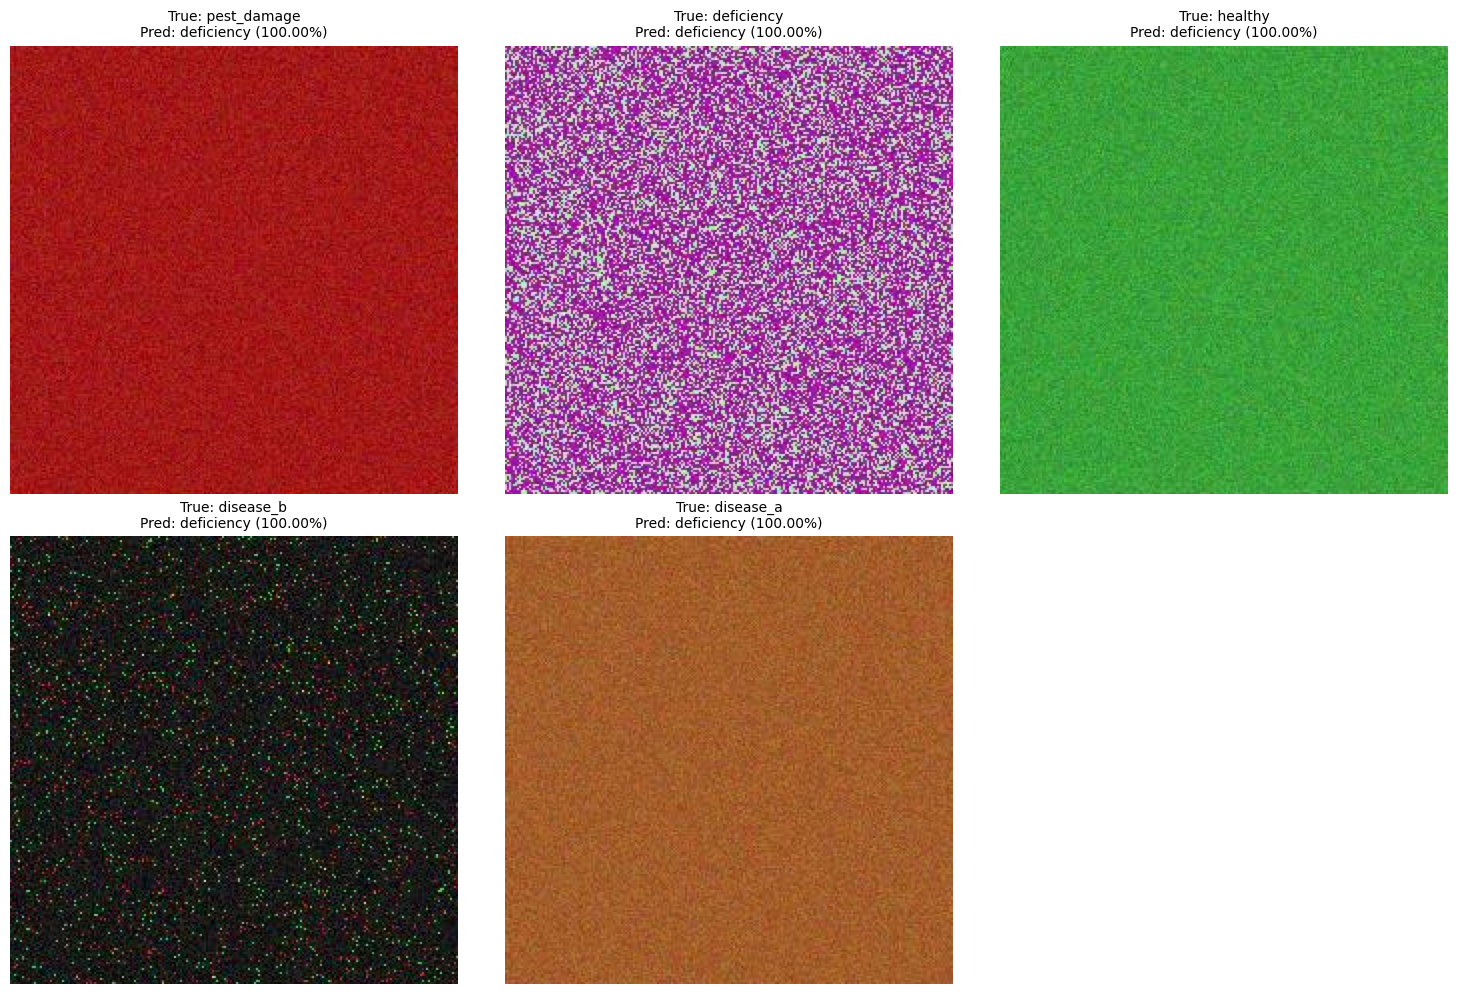

In [17]:
# Test on random images
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array, verbose=0)
    top_idx = np.argsort(predictions[0])[::-1][:3]

    return [(class_names[i], predictions[0][i]) for i in top_idx]

# Get random test images
test_images = []
for class_dir in DATASET_PATH.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
        if images:
            test_images.append(random.choice(images))

# Display predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    if i < len(test_images):
        img_path = test_images[i]
        img = Image.open(img_path)
        predictions = predict_image(img_path)

        ax.imshow(img)
        title = f"True: {img_path.parent.name[:15]}\n"
        title += f"Pred: {predictions[0][0][:15]} ({predictions[0][1]:.2%})"
        ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 9. Export Model

In [18]:
# List exported models
!ls -lh ./output/models/

total 92M
-rw-r--r-- 1 root root  38M Jan  6 15:40 agriculture_model.h5
-rw-r--r-- 1 root root  38M Jan  6 15:40 agriculture_model.keras
-rw-r--r-- 1 root root  17M Jan  6 15:41 agriculture_model.onnx
drwxr-xr-x 4 root root 4.0K Jan  6 15:41 agriculture_model_savedmodel
-rw-r--r-- 1 root root   78 Jan  6 15:19 class_names.json


In [19]:
# Download model files
from google.colab import files

# Create a zip of all output files
!zip -r model_export.zip ./output/models/ ./output/training_summary.json ./output/training_curves.png

files.download('model_export.zip')
print("\n✅ Model exported! Upload the .h5 or .onnx file to your cloud API.")

  adding: output/models/ (stored 0%)
  adding: output/models/agriculture_model.onnx (deflated 8%)
  adding: output/models/agriculture_model_savedmodel/ (stored 0%)
  adding: output/models/agriculture_model_savedmodel/saved_model.pb (deflated 91%)
  adding: output/models/agriculture_model_savedmodel/variables/ (stored 0%)
  adding: output/models/agriculture_model_savedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: output/models/agriculture_model_savedmodel/variables/variables.index (deflated 77%)
  adding: output/models/agriculture_model_savedmodel/assets/ (stored 0%)
  adding: output/models/agriculture_model_savedmodel/fingerprint.pb (stored 0%)
  adding: output/models/agriculture_model.h5 (deflated 9%)
  adding: output/models/agriculture_model.keras (deflated 10%)
  adding: output/models/class_names.json (deflated 29%)
  adding: output/training_summary.json (deflated 47%)
  adding: output/training_curves.png (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Model exported! Upload the .h5 or .onnx file to your cloud API.


## 10. Next Steps

1. **Deploy the model**: Upload `agriculture_model.h5` or `agriculture_model.onnx` to your cloud API
2. **Test the API**: Use the web interface to test image analysis
3. **Improve accuracy**: Try different backbones, more data, or longer training

### Files to download:
- `agriculture_model.h5` - TensorFlow/Keras model
- `agriculture_model.onnx` - ONNX model (faster inference)
- `class_names.json` - Class labels mapping
- `training_summary.json` - Training configuration and results